# Visualize low dimensional projections of CNN codebooks

### Imports

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [2]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


### Instantiate vgg models

In [22]:
vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                 n_pops=0)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=1)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=3)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=5)


/opt/anaconda/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1000)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


### Compute codebooks for artificial stimuli and visualize low-d manifold

In [23]:
from sklearn.manifold import TSNE, MDS, SpectralEmbedding

### Hue

#### Codebook

In [24]:
hue = np.linspace(0, 359, 360)
rgb_list = list()

Xplain_vgg = list()
stimpath = '../V4pydata'

#for stim_id in range(360):
for a, ang in enumerate(hue):
    imname = '/stimuli/M3/Hues/img%03d.jpg' % np.floor(ang)
    filename = stimpath + imname
    I = cv2.imread(filename)
    I_for_vgg = V4.prepare_image_for_vgg(I)
    rgb_list.append(I[0,0,:][::-1])
    Xplain_vgg.append(np.squeeze(vgg_model.predict(I_for_vgg)))
Xplain_vgg = np.array(Xplain_vgg)

In [25]:
Xplain_vgg.shape

(360, 1000)

#### Visualize

In [26]:
se = SpectralEmbedding(n_components=2)
X_lowd = se.fit_transform(Xplain_vgg)

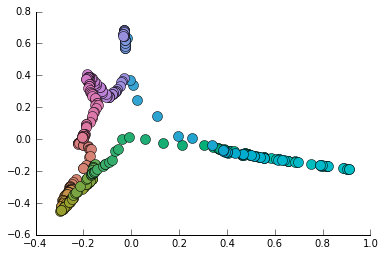

In [27]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', ms=10, c=rgb_list[im].astype(float) / 255.0)
V4.simpleaxis(ax)
plt.savefig('L8_hue_embedding.pdf', format='pdf')
plt.show()

### Orientation

#### Codebook

In [9]:
def make_sine_grating(n_pixels=224, theta=0, spatial_freq=0.03, phase=0):
    
    # Design the grating
    [x, y] = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels))
    theta = 180. - theta
    x_theta = x * np.cos(theta / 180. * np.pi) + y * np.sin(theta / 180. * np.pi)
    y_theta = -x * np.sin(theta / 180. * np.pi) + y * np.cos(theta / 180. * np.pi)
    grating = (1. + np.cos(2 * np.pi * spatial_freq * x_theta + phase / 180. * np.pi))/ 2.
    
    # Make it into an image
    G = np.zeros((n_pixels, n_pixels, 3))
    G[:, :, 0] = grating * 255.
    G[:, :, 1] = grating * 255.
    G[:, :, 2] = grating * 255.    
    return np.uint8(G)

In [10]:
ori = np.linspace(0., 179., 180)
rgb_list_ori = list()
Xgrating_vgg = list()
# Extract vgg features for oriented gratings
Xgrating_vgg = list()
for a, ang in enumerate(ori):
    G = make_sine_grating(theta=ang, phase=0.)
    G_for_vgg = V4.prepare_image_for_vgg(G)
    Xgrating_vgg.append(np.squeeze(vgg_model.predict(G_for_vgg)))
    rgb_list_ori.append(rgb_list[2 * a])
Xgrating_vgg = np.array(Xgrating_vgg)

In [11]:
Xgrating_vgg.shape

(180, 25088)

In [12]:
len(rgb_list_ori)

180

#### Visualize

In [13]:
se = SpectralEmbedding(n_components=2)
X_lowd = se.fit_transform(Xgrating_vgg)

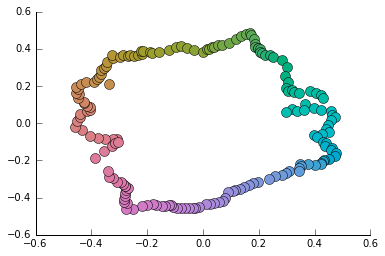

In [14]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', ms=10, c=rgb_list_ori[im].astype(float) / 255.0)
V4.simpleaxis(ax)
#plt.axis([-50, 50, -50, 50])
plt.show()